# Тестовое задание: "Анализ данных о займах"ент взятия займа.
 

Данное тестовое задание ориентировано на проведение разведочного анализа данных о займах за 2023 год и включает в себя три основных задачи:

1. Проведение разведочного анализа займов в разрезе рейтингов.
2. Иллюстрация изменения отношения Non-performing займов к общей выдаче займов до текущего дня.
3. Когортный анализ дефолтности в разрезе месяца выдачи займа.

***Описание***

Первоначально, я проверю данные на ошибки и оценю их влияние на исследование. Затем, на этапе предобработки я поищу возможность исправить все ошибки данных, которые не приведут к искажению конечного результата. Далее приступлю к разведочный анализу займов в разрезе рейтингов и после, посмотрю на отношение займов к общей выдаче. Завершу исследование когортным анализом дефолтности в разрезе месяца выдачи займа. По итогам исследования напишу общий вывод и предоставлю рекомендации.

Таким образом, моё исследование пройдёт в 6 этапов.

***Декомпозиция***

1. Загрузка и обзор данных.
2. Предобработка данных.
3. Разведочный анализ займов в разрезе рейтингов.
4. Отношение займов к общей выдаче.
5. Когортный анализ дефолтности в разрезе месяца выдачи займа.
6. Общий вывод.

***Использование данных***

Для выполнения задания предоставлен файл loan_data.csv, содержащий информацию о займах за 2023 год. Файл содержит следующие поля:


id: Идентификатор займа.

number: Порядковый номер платежа.

payment_date: Дата платежа.

status: Статус платежа.

amount: Сумма платежа.

start_date: Дата взятия займа.

loan_rating_int: Рейтинг займа.

loan_status_str: Статус займа.

restruct_status: Статус реструктуризации.

auto_approval: Был ли займ одобрен автоматически.

borrower_issue_class: Класс заемщика на момент взятия займа.


## 1. Загрузка и обзор данных

In [1]:
try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import plotly.express as px
    import datetime as dt
    import calendar
    import plotly.graph_objects as go
except ImportError as e:
    print("Ошибка импорта: ", e)

In [2]:
url = 'https://drive.google.com/uc?export=download&id=1f8lS-prMgZnBHOrSg0JFHFF3NVno1Cle'

df = pd.read_csv(url)

In [3]:
#уберем пропуски в названиях столбцов и приведем к нижнему регистру
df.columns = df.columns.str.lower().str.strip()

In [4]:
print(df.head())

      id  number         payment_date status    amount  \
0  12436       1  2023-02-20T03:00:00   paid  532362.0   
1  12436       2  2023-03-20T03:00:00   paid  521224.0   
2  12436       3  2023-04-20T03:00:00   paid  522177.0   
3  12436       4  2023-05-20T03:00:00   paid  521007.0   
4  12436       5  2023-06-20T03:00:00   paid  520816.0   

                   start_date  loan_rating_int loan_status_str  \
0  2023-01-04T15:22:07.106088               10          active   
1  2023-01-04T15:22:07.106088               10          active   
2  2023-01-04T15:22:07.106088               10          active   
3  2023-01-04T15:22:07.106088               10          active   
4  2023-01-04T15:22:07.106088               10          active   

  restruct_status    auto_approval borrower_issue_class  
0     no restruct  No auto-approve          4. platinum  
1     no restruct  No auto-approve          4. platinum  
2     no restruct  No auto-approve          4. platinum  
3     no restruct  No 

Можем заметить, что нужно привести колонки payment_date и start_date к корректному типу.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71025 entries, 0 to 71024
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    71025 non-null  int64  
 1   number                71025 non-null  int64  
 2   payment_date          70981 non-null  object 
 3   status                71025 non-null  object 
 4   amount                71025 non-null  float64
 5   start_date            71025 non-null  object 
 6   loan_rating_int       71025 non-null  int64  
 7   loan_status_str       71025 non-null  object 
 8   restruct_status       71025 non-null  object 
 9   auto_approval         71025 non-null  object 
 10  borrower_issue_class  71025 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 6.0+ MB


Имеются пропуски в payment_date          

In [6]:
for col in df.columns:
    print(f'{col}: {df[col].nunique()}', end='; ')

id: 4712; number: 59; payment_date: 1420; status: 6; amount: 66880; start_date: 4712; loan_rating_int: 18; loan_status_str: 4; restruct_status: 2; auto_approval: 2; borrower_issue_class: 5; 

### Промежуточный вывод

Из обзора данных можно заметить:

В нашем распоряжении датафрейм с 11 столбцами и 71025 строками. Названия столбцов корректны. В payment_date имеются пропущеные значения, нужно обратить на это внимание. Также, стоит изменить тип данных времени событий и провести привычную перобработку на дубликаты, выбросы и прочее. При необходимости можно будет добавить дополнительные столбцы, чтобы облегчить ход исследования.

По первым наблюдениям: всего в 4712 уникальных айди с 59 порядковыми номерами. Имеется 6 статусов платежа, 2 статуса реструктуризации, 5 классов заемщика и отметка одобрен займ или нет.

## 2. Предобработка

### 2.1 Пропуски

In [7]:
pd.DataFrame((df.isna().mean() * 100).round(2)).style.background_gradient('coolwarm')

,0
id,0.000000
number,0.000000
payment_date,0.060000
status,0.000000
amount,0.000000
start_date,0.000000
loan_rating_int,0.000000
loan_status_str,0.000000
restruct_status,0.000000
auto_approval,0.000000


In [8]:
df[df['payment_date'].isna() == True]

,id,number,payment_date,status,amount,start_date,loan_rating_int,loan_status_str,restruct_status,auto_approval,borrower_issue_class
1070,12566,7,NaN,paid,3158.210,2023-01-17T08:36:05.306626,16,closed,no restruct,No auto-approve,2. silver
2745,12713,13,NaN,paid,705.333,2023-02-02T20:37:34.901188,14,closed,no restruct,No auto-approve,2. silver
3227,12751,9,NaN,paid,373.116,2023-02-01T05:09:56.449434,17,closed,no restruct,No auto-approve,3. gold
4076,12820,7,NaN,potential default,148505.000,2023-02-08T19:44:17.51937,18,default,no restruct,No auto-approve,2. silver
4760,12878,13,NaN,paid,872.680,2023-02-14T10:29:25.249524,16,closed,no restruct,No auto-approve,2. silver
5785,12973,11,NaN,paid,4602.920,2023-02-21T10:55:16.721167,15,closed,no restruct,No auto-approve,2. silver
5938,12986,9,NaN,paid,5224.080,2023-02-23T17:19:33.111559,14,closed,no restruct,No auto-approve,2. silver
6033,12994,13,NaN,paid,3296.010,2023-02-27T16:10:00.355529,16,closed,no restruct,No auto-approve,2. silver
6071,12997,2,NaN,paid,9927.180,2023-02-28T13:08:05.109576,18,closed,no restruct,No auto-approve,2. silver
6584,13038,13,NaN,paid,5044.220,2023-02-28T14:27:49.993586,18,closed,no restruct,No auto-approve,1. bronze


In [9]:
df = df.dropna()

Удаляем пропуски в колонке даты платежа, т.к. их количество слишком мало и не повлияет на исследование. 

### 2.2 Типы данных

In [10]:
df['payment_date'] = pd.to_datetime(df['payment_date'])

In [11]:
# Если в строке не указаны миллисекунды, то добавляем их
def add_milliseconds(date_str):
    if '.' not in date_str:
        return date_str + '.000'
    return date_str

df['start_date'] = df['start_date'].apply(add_milliseconds)

df['start_date'] = pd.to_datetime(df['start_date'], format='%Y-%m-%dT%H:%M:%S.%f')

В колонке даты взятия займа не везде указаны миллисекунды, скорее всего это связано с тем, что их значение равно нулю, поэтому добавляем для преобразования к типу даты.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70981 entries, 0 to 71024
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    70981 non-null  int64         
 1   number                70981 non-null  int64         
 2   payment_date          70981 non-null  datetime64[ns]
 3   status                70981 non-null  object        
 4   amount                70981 non-null  float64       
 5   start_date            70981 non-null  datetime64[ns]
 6   loan_rating_int       70981 non-null  int64         
 7   loan_status_str       70981 non-null  object        
 8   restruct_status       70981 non-null  object        
 9   auto_approval         70981 non-null  object        
 10  borrower_issue_class  70981 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(3), object(5)
memory usage: 6.5+ MB


### 2.3 Дубликаты

In [13]:
df.duplicated().sum()

0

Явных дубликатов в датафрейме не обнаружено.

### 2.4 Выбросы

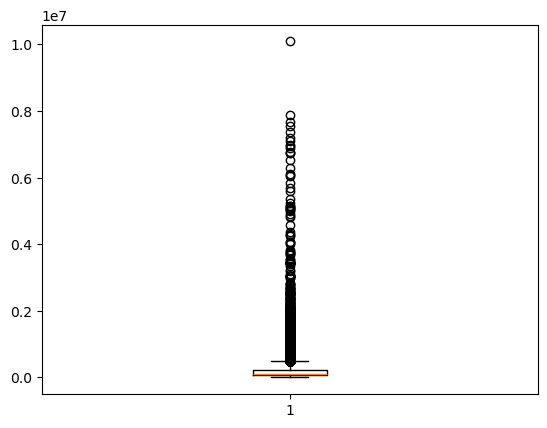

In [14]:
plt.boxplot(df['amount']);

In [15]:
np.percentile(df['amount'], [90,95,99])

array([368408.        , 503465.        , 938154.39999999])

In [16]:
df[df['amount'] > 938154.39999999]

,id,number,payment_date,status,amount,start_date,loan_rating_int,loan_status_str,restruct_status,auto_approval,borrower_issue_class
76,12483,5,2023-05-03 03:00:00,paid,6979590.0,2023-01-09 16:36:02.772381,13,closed,no restruct,No auto-approve,2. silver
414,12509,2,2023-03-11 03:00:00,paid,1082020.0,2023-01-10 23:13:43.974060,8,closed,no restruct,No auto-approve,2. silver
415,12509,3,2023-04-11 03:00:00,paid,2141580.0,2023-01-10 23:13:43.974060,8,closed,no restruct,No auto-approve,2. silver
637,12523,10,2023-10-12 03:00:00,paid,1122550.0,2023-01-13 11:59:25.508074,12,closed,no restruct,No auto-approve,3. gold
716,12528,4,2023-05-18 03:00:00,paid,2023620.0,2023-01-12 14:23:25.603894,12,closed,no restruct,No auto-approve,2. silver
...,...,...,...,...,...,...,...,...,...,...,...
68981,18206,6,2024-06-26 03:00:00,unscheduled,2530330.0,2023-12-29 18:10:04.288257,9,active,no restruct,No auto-approve,5. diamond
68982,18206,7,2024-07-26 03:00:00,unscheduled,2524090.0,2023-12-29 18:10:04.288257,9,active,no restruct,No auto-approve,5. diamond
68983,18206,8,2024-08-26 03:00:00,unscheduled,2529610.0,2023-12-29 18:10:04.288257,9,active,no restruct,No auto-approve,5. diamond
70494,18325,1,2024-01-31 03:00:00,paid,1286000.0,2023-12-30 16:20:22.149601,9,closed,no restruct,No auto-approve,2. silver


Не более 1% заказов с суммой платежа более 938154. Уберем эти значения, чтобы не исказить общую картину. Как мы можем видеть в основном это заказы со статусом closed, т.е. возможно завышенные суммы платежей в которых отказано или исключения в виде класса diamond.

In [17]:
df = df[df['amount'] <= 938154.39999999]

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70271 entries, 0 to 71024
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    70271 non-null  int64         
 1   number                70271 non-null  int64         
 2   payment_date          70271 non-null  datetime64[ns]
 3   status                70271 non-null  object        
 4   amount                70271 non-null  float64       
 5   start_date            70271 non-null  datetime64[ns]
 6   loan_rating_int       70271 non-null  int64         
 7   loan_status_str       70271 non-null  object        
 8   restruct_status       70271 non-null  object        
 9   auto_approval         70271 non-null  object        
 10  borrower_issue_class  70271 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(3), object(5)
memory usage: 6.4+ MB


Потеряли 710 строк.

In [19]:
print("Минимальная дата взятия займа -", df['start_date'].min(), "Максимальная дата взятия займа -", df['start_date'].max())

Минимальная дата взятия займа - 2023-01-01 09:24:53.918126 Максимальная дата взятия займа - 2023-12-31 13:48:46.261717


Даты действительно, исключительно за 2023 год.

### 2.5 Добавление новых столбцов

In [20]:
intervals = [0, 11, 15, 18]  # Интервалы для низкого, среднего и высокого рейтинга
labels = ['Низкий', 'Средний', 'Высокий']

# Добавьте новый столбец с группами рейтингов
df['rating_group'] = pd.cut(df['loan_rating_int'], bins=intervals, labels=labels, include_lowest=True)


Для удобства добавим категоризацию для рейтинга, создав колонку с разбивкой по рейтингам. 

Низкий рейтинг: от 0 до 10 включительно, средний рейтинг: от 11 до 14 включительно, высокий рейтинг: от 15 до 18 включительно. Размер групп примерно равный. ный.

###  Промежуточный вывод

1. Решено удалить пропуски, так как они составляют менее 1% данных, чтобы сохранить качество данных без искажения общей картины.


2. В колонке с датой взятия займа добавлены нулевые миллисекунды для преобразования к типу даты.


3. Дубликатов не обнаружено, что свидетельствует о хорошем качестве данных и отсутствии повторяющейся информации.


4. Обнаружено, что не более 1% заказов имеют сумму платежа более 938154. Удаление этих значений помогло избежать искажения общей картины. Это часто связано с заказами со статусом "closed" или классом "diamond", что может указывать на завышенные суммы платежей или исключительные случаи. Удаление привело к потере 710 строк.


5. Подтверждено, что даты относятся исключительно к 2023 году, что устанавливает временной контекст данных.


6. Добавлена категоризация для рейтинга, что упрощает классификацию данных и проведение анализа по различным уровням рейтинга: низкому, среднему и высокому. Этот подход поможет облегчить интерпретацию результатов и выявление закономерностей.

## 3. Разведочный анализ займов в разрезе рейтингов

### 3.1 По всем рейтингам

In [21]:
loan_rating_cnt = df.groupby('loan_rating_int')['id'].nunique().sort_values(ascending=False)
loan_rating_cnt

loan_rating_int
16    843
17    504
18    494
12    396
11    395
13    354
14    307
15    303
9     272
10    240
7     196
8     119
6      73
5      35
3      32
4      19
2       4
1       4
Name: id, dtype: int64

Больше всего займов с высокими рейтингами: 16 - 843, 17 - 504, 18 - 494. Меньше всего с низкими рейтингами 1 - 4, 2 - 4, 4 - 19.

In [22]:
loan_rating_sum = df.groupby('loan_rating_int')['amount'].sum().reset_index()

loan_rating_sum = loan_rating_sum.sort_values(by='amount', ascending=False)
loan_rating_sum

,loan_rating_int,amount
15,16,1.533483e+09
10,11,1.222573e+09
11,12,1.132468e+09
8,9,1.004413e+09
16,17,1.003733e+09
12,13,9.732362e+08
13,14,8.178720e+08
6,7,7.900503e+08
17,18,7.550085e+08
14,15,7.363839e+08


Самые большие суммы платежа у рейтинга 16. За ним идут 11,12,9. 

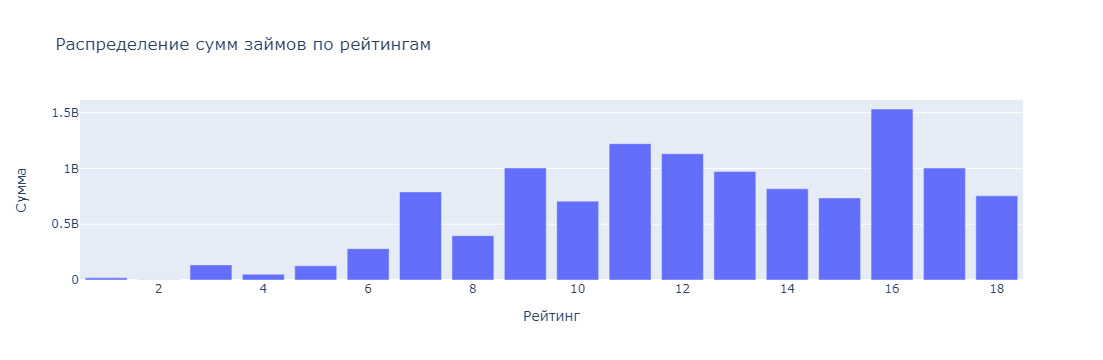

In [42]:
fig = px.bar(loan_rating_sum, x='loan_rating_int', y='amount', title='Распределение сумм займов по рейтингам')

# Подпись осей
fig.update_xaxes(title_text='Рейтинг')
fig.update_yaxes(title_text='Сумма')

fig.show()


Рейтинг 16 заметно выделяется по сумме займов. Среди низких рейтингов стоит обратить внимание на рейтинг 7 и 9. Средние рейтинги 11 и 12, так же имеют большие суммы.

### 3.2 По группам рейтингов

In [24]:
df.groupby('rating_group', observed=False)['id'].nunique().sort_values(ascending=False)

rating_group
Высокий    1841
Низкий     1389
Средний    1360
Name: id, dtype: int64

Разделение с 0 до 10, с 10 до 15 и с 16 до 18 разделило рейтинг на примерно равные группы.

In [25]:
rating_group_sum = df.groupby('rating_group', observed=False)['amount'].sum().sort_values(ascending=False).reset_index()
rating_group_sum

,rating_group,amount
0,Низкий,4.737410e+09
1,Средний,3.659960e+09
2,Высокий,3.292224e+09


У группы с низким рейтингом больше всего общая сумма платежа, меньше всего у высоких.

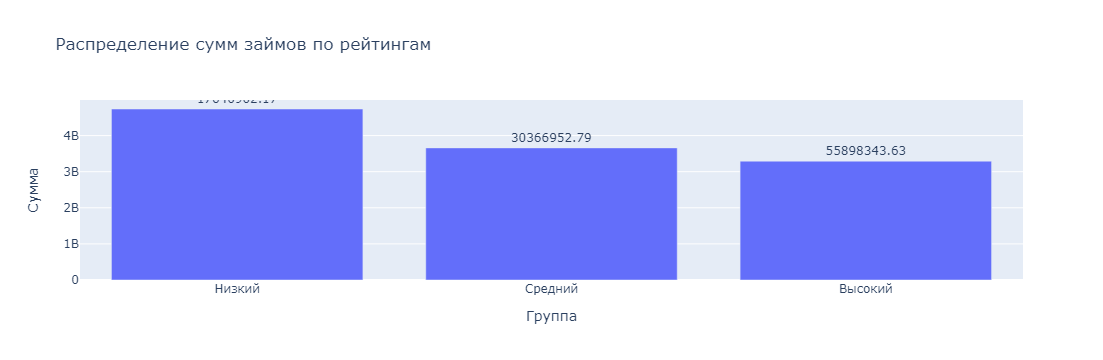

In [40]:
fig = px.bar(rating_group_sum, x='rating_group', y='amount', title='Распределение сумм займов по рейтингам')

# Подпись осей
fig.update_xaxes(title_text='Группа')
fig.update_yaxes(title_text='Сумма')

# Вывод значений на график
fig.update_traces(text=default_sum['amount'].round(2), textposition='outside')

fig.show()

Можно предположить, что чем выше рейтинг, тем меньше общая сумма платежей.

###  Промежуточный вывод

1. Наблюдается явная тенденция: займы с высоким рейтингом (16, 17, 18) преобладают в общем числе займов, в то время как займы с низким рейтингом (1, 2, 4) составляют лишь небольшую часть.


2. Заемщики с займами рейтинга 16 чаще всего выплачивают самые крупные суммы, за которыми следуют займы с рейтингами 11, 12 и 9.


3. Рейтинг 16 выделяется как по количеству займов, так и по суммам, при этом также стоит обратить внимание на займы с рейтингами 7 и 9 среди низких рейтингов, а также на рейтинги 11 и 12 среди средних.


4. Разделение займов на три примерно равные группы по рейтингу (0-10, 10-15, 16-18) подразумевает существенные различия между этими группами.


5. Займы с низким рейтингом имеют наибольшую общую сумму платежей, в то время как у займов с высоким рейтингом эта сумма наименьшая.


6. Предполагается обратная зависимость между рейтингом займа и общей суммой платежей, что может указывать на то, что займы с более высоким рейтингом склонны к более низким суммам платежей.

## 4. Отношение займов npl к общей выдаче 

In [27]:
df['status'].unique()

array(['paid', 'next', 'unscheduled', 'overdue', 'potential default',
       'defaulted'], dtype=object)

In [28]:
overdue_statuses = ['overdue', 'potential default', 'defaulted']

df['new_status'] = df['status'].replace(overdue_statuses, 'overdue_statuses')

Определим в одну группу статусы займов overdue, potential default и defaulted.

In [29]:
today = pd.Timestamp(dt.date.today())

today_df = df[df['payment_date'] <= today]

Делаем срез до текущего дня

In [30]:
npl = today_df.pivot_table(index='payment_date', 
                             values='amount', 
                             aggfunc='sum', 
                             columns=df['new_status'].eq('overdue_statuses'))

npl.columns = ['total', 'overdue_statuses']


npl['ratio'] = npl['total'] / npl['overdue_statuses']


npl = npl.fillna(0).reset_index()

C:\Users\Matvey Wonder\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



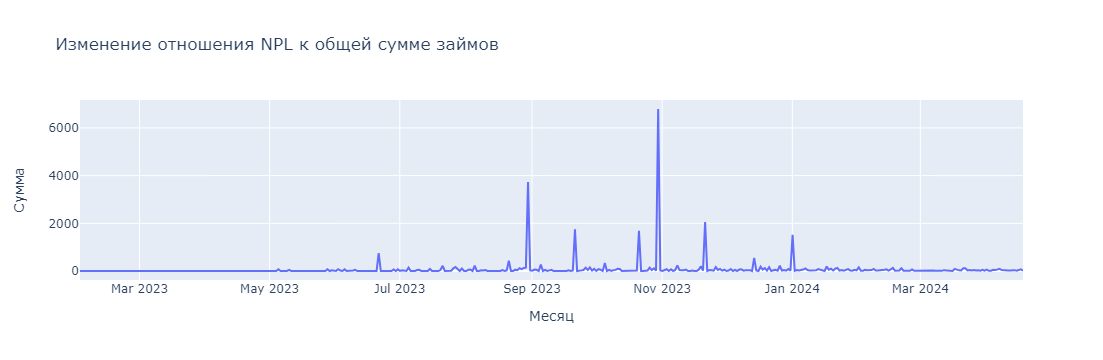

In [39]:
fig = px.line(npl, x='payment_date', y='ratio', title='Изменение отношения NPL к общей сумме займов')

# Подпись осей
fig.update_xaxes(title_text='Месяц')
fig.update_yaxes(title_text='Сумма')

fig.show()


Можем наблюдать явные пики в некоторых датах, особенно стоит обратить внимание на 30 октября и 30 августа. В эти дни отношение npl займов к общей сумме займов наибольшее.

###  Промежуточный вывод

1. Анализ отношения займов с просрочкой к общей выдаче позволяет выявить временные пики в определенные даты, особенно значимыми являются 30 октября и 30 августа.

2. 
В указанные даты наблюдается наибольшее отношение просроченных, потенциально дефолтных и дефолтных займов к общей сумме выданных займов.

3. 
Пики в отношении неплатежеспособных займов к общей выдаче могут указывать на потенциальные проблемы в платежеспособности заемщиков или на особенности временной динамики рынка

4. .
Дальнейший анализ и исследование причин пиков в отношении неплатежеспособных займов в указанные даты могут помочь предпринять соответствующие меры для снижения рисков и оптимизации процессов выдачи займов.

## 5. Когортный анализ дефолтности в разрезе месяца выдачи займа 

### 5.1 Когорты

In [32]:
df['borrower_issue_class'].value_counts()

borrower_issue_class
2. silver      46484
1. bronze       8160
3. gold         6147
4. platinum     6082
5. diamond      3398
Name: count, dtype: int64

Разбить на когорты по уровню статуса клиента будет не очень корректно, т. к. они имеют существенное различие в количестве клиентов.

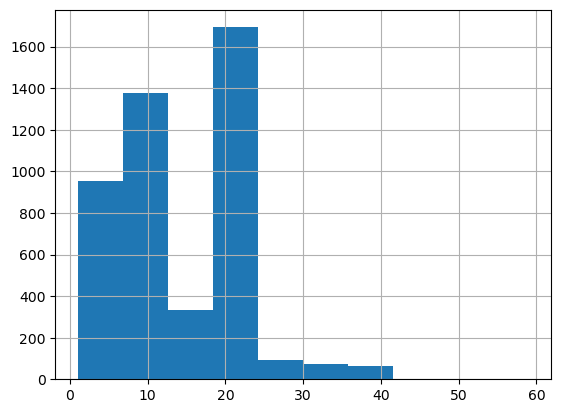

In [33]:
number_cnt = df.groupby('id')['number'].count()
number_cnt.hist();

number_cnt = number_cnt.reset_index()

Можем наблюдать: всего у займов количество платежей находится в диапозоне от 1 до чуть больше 40; 
наибольшее число займов с количеством платежей с 1 до около 10 и в районе 20-25.

Можно рассмотреть разбивку на когорты по количеству платежей.

In [34]:
user_orders = df.groupby('id').size().reset_index(name='cnt_number')

# Добавление колонки с описанием количества заказов
user_orders['cnt_number'] = pd.cut(user_orders['cnt_number'], 
                                          bins=[-float("inf"), 10, 20, float("inf")], 
                                          labels=['мало', 'средне', 'много'])

# Объединение с исходным датафреймом по id
df = df.merge(user_orders[['id', 'cnt_number']], on='id', how='left')

In [35]:
df.groupby('cnt_number', observed=False)['id'].nunique().reset_index()

,cnt_number,id
0,мало,1248
1,средне,1615
2,много,1727


При разбивке на когорты, где у займа от 0 до 10 платежей (мало), от 11 до 20 (средне) и от 21 и далее получились примерно равные когорты по количеству займов.
мало - 1248;
средне - 1615;
много - 1727.


### 5.2 Анализ дефолтности в разрезе месяца

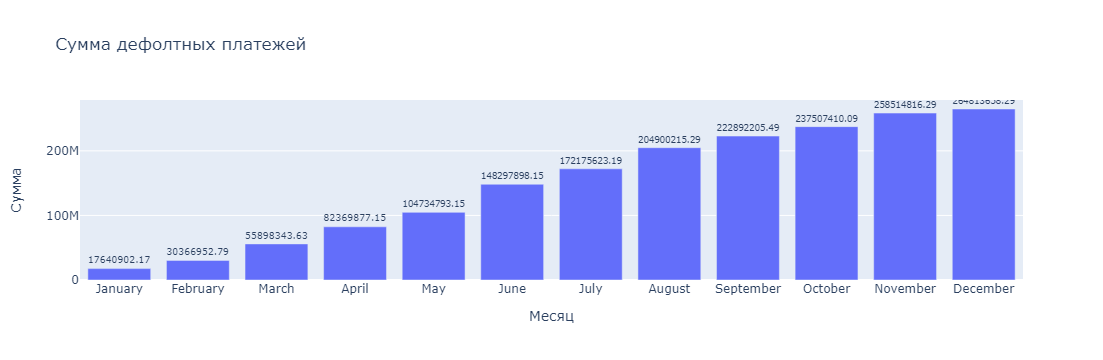

In [36]:
df['month'] = df['start_date'].dt.to_period('M')

defaulted_df = df.loc[df['status'] == 'defaulted'].copy()

default_sum = defaulted_df.groupby('month')['amount'].sum().cumsum().reset_index()

# Заменим на названия месяца для наглядности
default_sum['month'] = default_sum['month'].astype(str)
default_sum['month'] = default_sum['month'].apply(lambda x: calendar.month_name[int(x.split('-')[1])])

fig = px.bar(default_sum, x='month', y='amount', title='Сумма дефолтных платежей')

# Подпись осей
fig.update_xaxes(title_text='Месяц')
fig.update_yaxes(title_text='Сумма')

# Вывод значений на график
fig.update_traces(text=default_sum['amount'].round(2), textposition='outside')

# Отображение графика
fig.show()


По общей сумме дефолтных платежей с накоплением в разрезе по месяцам видно, что:
1. На конец года сумма достигает 264,8 млн
2. В целом сумма растет довольно стабильно

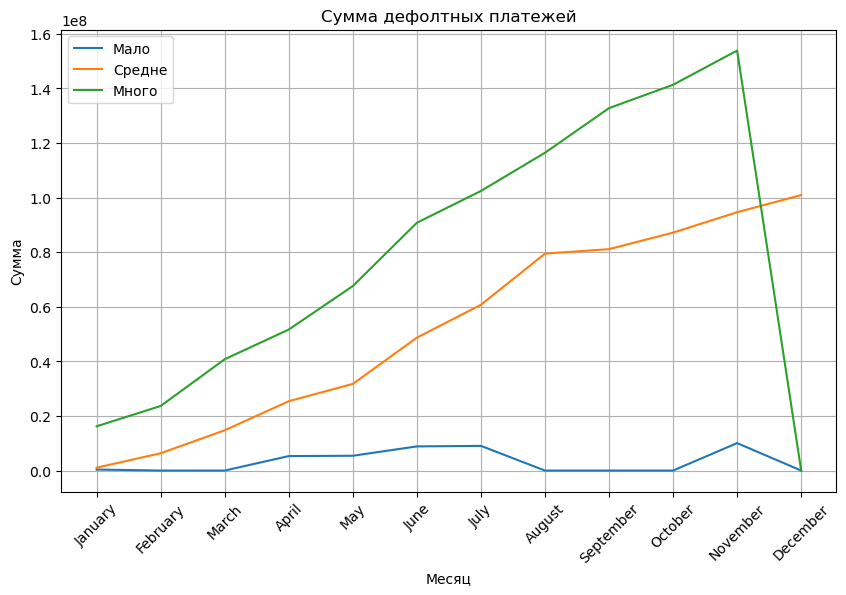

In [37]:
# Группировка и суммирование для каждого значения cnt_number
default_sum_1 = df.query("cnt_number == 'мало' and status == 'defaulted'").groupby('month')['amount'].sum().cumsum().reset_index()
default_sum_2 = df.query("cnt_number == 'средне' and status == 'defaulted'").groupby('month')['amount'].sum().cumsum().reset_index()
default_sum_3 = df.query("cnt_number == 'много' and status == 'defaulted'").groupby('month')['amount'].sum().cumsum().reset_index()

# Преобразуем столбец month в индекс
default_sum_1.set_index('month', inplace=True)
default_sum_2.set_index('month', inplace=True)
default_sum_3.set_index('month', inplace=True)

# Объединяем индексы всех кадров данных
idx = default_sum_1.index.union(default_sum_2.index).union(default_sum_3.index)

# Переиндексируем все кадры данных, заполняя отсутствующие значения нулями
default_sum_1 = default_sum_1.reindex(idx, fill_value=0)
default_sum_2 = default_sum_2.reindex(idx, fill_value=0)
default_sum_3 = default_sum_3.reindex(idx, fill_value=0)

# Сбросим индекс для возврата 'month' в столбец
default_sum_1.reset_index(inplace=True)
default_sum_2.reset_index(inplace=True)
default_sum_3.reset_index(inplace=True)

# Замена на названия месяца для наглядности
default_sum_1['month'] = default_sum_1['month'].astype(str).apply(lambda x: calendar.month_name[int(x.split('-')[1])])
default_sum_2['month'] = default_sum_2['month'].astype(str).apply(lambda x: calendar.month_name[int(x.split('-')[1])])
default_sum_3['month'] = default_sum_3['month'].astype(str).apply(lambda x: calendar.month_name[int(x.split('-')[1])])

# Создание графика
plt.figure(figsize=(10, 6))

# Слияние данных
merged_data = default_sum_1.merge(default_sum_2, on='month', suffixes=('_мало', '_средне')).merge(default_sum_3, on='month')

# Построение линий для каждого значения cnt_number
plt.plot(merged_data['month'], merged_data['amount_мало'], label='Мало')
plt.plot(merged_data['month'], merged_data['amount_средне'], label='Средне')
plt.plot(merged_data['month'], merged_data['amount'], label='Много')

# Настройка осей и легенды
plt.xlabel('Месяц')
plt.ylabel('Сумма')
plt.title('Сумма дефолтных платежей')
plt.legend()

# Поворот названий месяцев на оси x
plt.xticks(rotation=45)

# Отображение графика
plt.grid(True)
plt.show()


По общей сумме дефолтных платежей с накоплением в разрезе по месяцам и с разделением на когорты видно, что:

1. В зависимости от количества дефолтных платежей, увеличивается и их общая сумма, что логично.
2. В некоторые месяцы отсутствуют платежы и групп.
3. Займы с высоким и среднем количеством платежей стабильно растут по общей сумме, когда займы с малым количеством на протяжении нескольких месяцев стоят на месте и в целом не показывают большого роста.

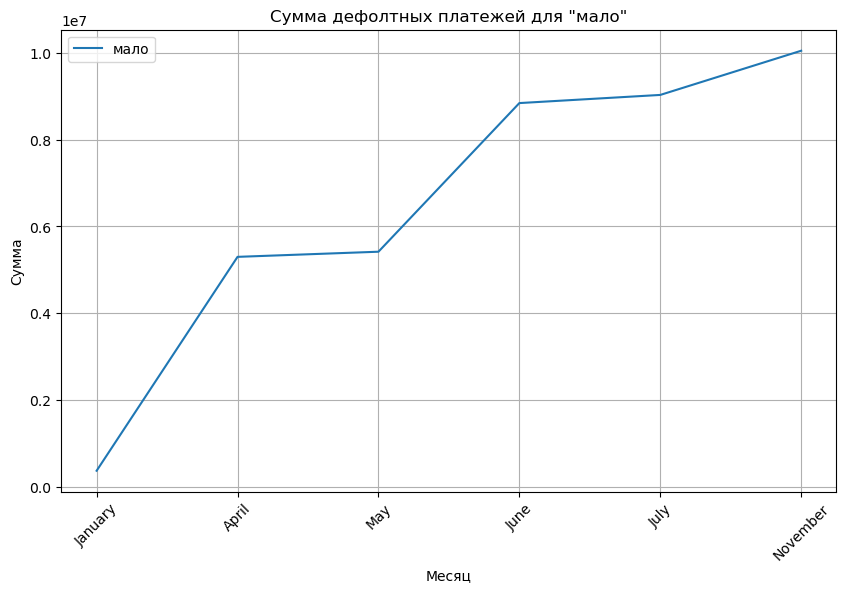

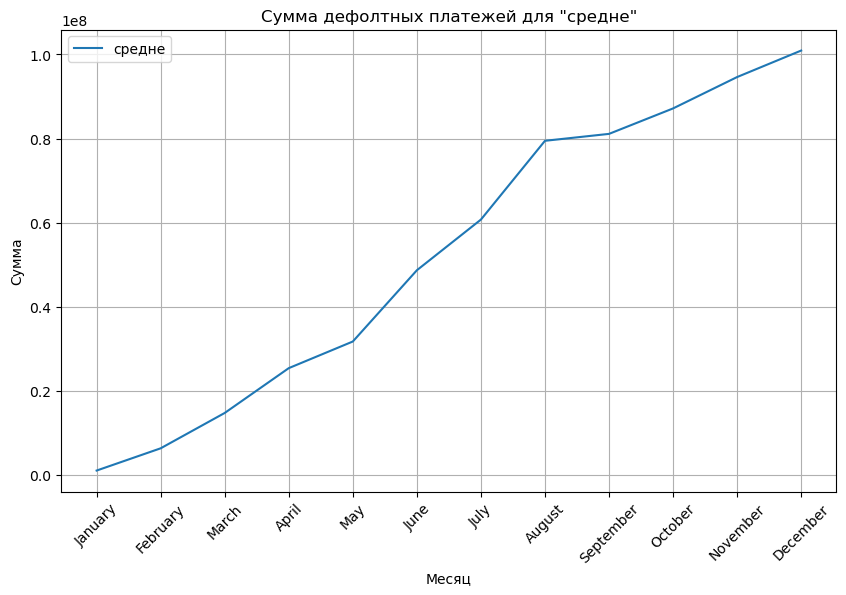

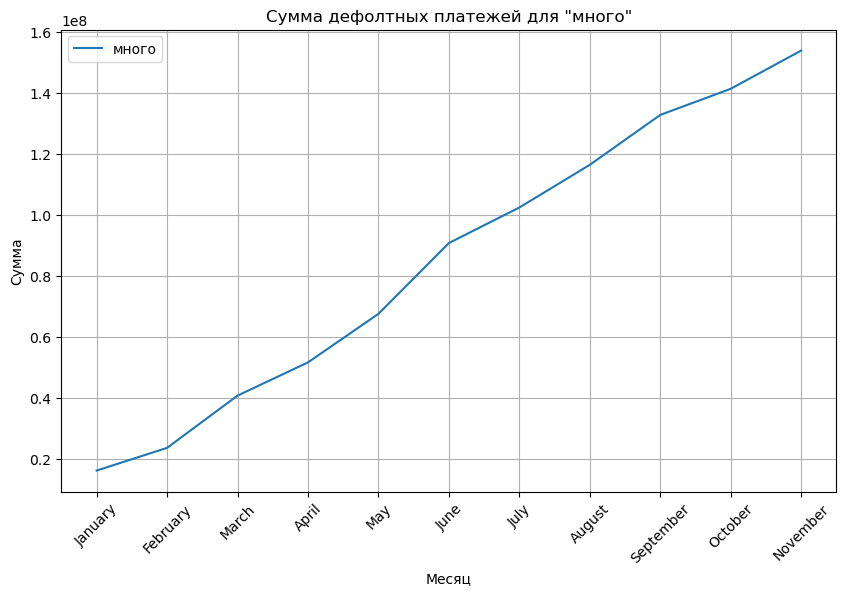

In [38]:
def plot_default_sum(df, cnt_number_values):
    for cnt_number in cnt_number_values:
        default_sum = df.query(f"cnt_number == '{cnt_number}' and status == 'defaulted'").groupby('month')['amount'].sum().cumsum().reset_index()
        default_sum.set_index('month', inplace=True)
        idx = default_sum.index.union(default_sum.index)
        default_sum = default_sum.reindex(idx, fill_value=0)
        default_sum.reset_index(inplace=True)
        default_sum['month'] = default_sum['month'].astype(str).apply(lambda x: calendar.month_name[int(x.split('-')[1])])

        plt.figure(figsize=(10, 6))
        plt.plot(default_sum['month'], default_sum['amount'], label=cnt_number)
        plt.xlabel('Месяц')
        plt.ylabel('Сумма')
        plt.title(f'Сумма дефолтных платежей для "{cnt_number}"')
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()

# Пример использования функции
plot_default_sum(df, ['мало', 'средне', 'много'])

1. У займов с малым количеством платежей отсутствуют дефолтные платежы в некоторые месяцы, а именно: Февраль, Март, Август, Сентябрь, Октябрь, Декабрь.
2. У средних платежей с августа по сентябрь наблюдается заметная остановка в росте суммы. Стоит обратить на это внимание.
3. Займы с большим количеством заказов на графике показывают наиболее стабильный рост.
4. У займов с большим количеством заказов отсутствуют дефолтные платежи за декабрь, на что нужно обратить внимание.

###  Промежуточный вывод

Анализ количества платежей показывает, что большинство займов имеют от 1 до около 10 платежей, а также в районе 20-25. Это может указывать на типичные сроки погашения займов.
Разбивка на когорты по количеству платежей позволяет выделить категории займов: малое количество платежей (до 10), среднее количество платежей (11-20) и большое количество платежей (21 и более). Общее количество займов в этих категориях примерно одинаково.
Общая сумма дефолтных платежей увеличивается со временем, причём рост довольно стабильный. Это может свидетельствовать о нарастающих проблемах с возвратом займов.
Разбивка общей суммы дефолтных платежей на когорты по количеству платежей показывает, что с увеличением количества платежей растёт и общая сумма дефолтных платежей, что логично.
Заметно, что в некоторые месяцы отсутствуют дефолтные платежи в определенных когортах займов. Это может свидетельствовать о специфических факторах, влияющих на возврат займов в эти периоды.
Стоит обратить внимание на замедление роста суммы дефолтных платежей у займов среднего количества платежей в период с августа по сентябрь.
Займы с большим количеством платежей показывают более стабильный рост по сравнению с другими категориями займов, однако следует обратить внимание на отсутствие дефолтных платежей в декабре в этой категории, возможно произошел сбой в системе или просто отсутствуют данные.

## 4. Общий вывод


На основе предоставленной информации о выполненной аналитической работе по разведочному анализу данных о займах за 2023 год можно сделать следующие выводы:

Главный вывод:
Займы с различным рейтингом демонстрируют значительные различия в динамике и поведении дефолтов. Займы с высоким рейтингом преобладают по количеству, но имеют наименьшие общие суммы платежей. Это может указывать на более консервативный подход к выдаче займов с высоким рейтингом и более низкую вероятность дефолта. Наблюдаемая обратная зависимость между рейтингом и суммой платежей подчеркивает, что более высокий рейтинг может коррелировать с более низкими рисками для кредитора.

Дополнительный вывод 1:
Исследование просроченных займов показывает временные пики в определенные даты, такие как 30 октября и 30 августа. Эти даты могут указывать на внешние или внутренние факторы, влияющие на способность заемщиков выполнять платежи, такие как экономические изменения или политики кредитования. Анализ этих дат может помочь кредиторам предпринять меры для уменьшения риска дефолта, возможно, путем изменения условий кредитования или даты выплаты.

Дополнительный вывод 2:
Когортный анализ дефолтности по месяцам выдачи показал, что общее количество дефолтных платежей растет со временем, что может свидетельствовать о нарастающих проблемах с возвратом займов. При этом, анализ показал, замедление роста дефолтов у займов средней категории в период с августа по сентябрь, в то время как займы с большим количеством платежей демонстрировали более стабильный рост. Наличие месяцев без дефолтных платежей в определенных категориях может указывать на специфические факторы, влияющие на возврат займов в эти периоды. Важно также обратить внимание на отсутствие дефолтных платежей в декабре среди займов с большим количеством платежей, что может свидетельствовать о возможном сбое в системе или недостатке данных.

Общие рекомендации:
На основе проведенного анализа рекомендуется внимательно отслеживать займы с различными рейтингами и адаптировать свои стратегии управления рисками исходя из обнаруженных зависимостей. Анализ дат пиковых просрочек может помочь в оптимизации даты выплат и улучшении коммуникации с заемщиками. Кроме того, периодический когортный анализ может предоставить дополнительную информацию по некоторым временным отрезкам для предотвращения дефолтов и улучшения финансовых результатов.